### ライブラリのインポート

In [4]:
# ライブラリのインポート
import os
import sys

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import MixtureSameFamily, Categorical

In [6]:
# 乱数シードを固定
torch.manual_seed(1234)

### 二次元正規分布を作成

In [7]:
# 次元を定義
dim = 2
# 平均0、共分散行列が二次元の単位行列の二次元正規分布を作成
dist = MultivariateNormal(torch.zeros((dim)), torch.eye(dim))

In [8]:
# サンプリング
sample = dist.sample()
print(f'----- サンプリング結果: {sample}')
print(f'----- サンプルの次元: {sample.shape[0]}')
# 対数尤度から尤度を計算
likelihood = torch.exp(dist.log_prob(sample))
print(f'----- 尤度: {likelihood}')

----- サンプリング結果: tensor([0.0461, 0.4024])
----- サンプルの次元: 2
----- 尤度: 0.14662088453769684


In [9]:
# 二次元の格子点の座標を作成
ls = np.linspace(-2, 2, 1000)
x, y = np.meshgrid(ls, ls)
point = torch.tensor(np.vstack([x.flatten(), y.flatten()]).T)
# 格子点の座標における尤度を算出
p = torch.exp(dist.log_prob(point))

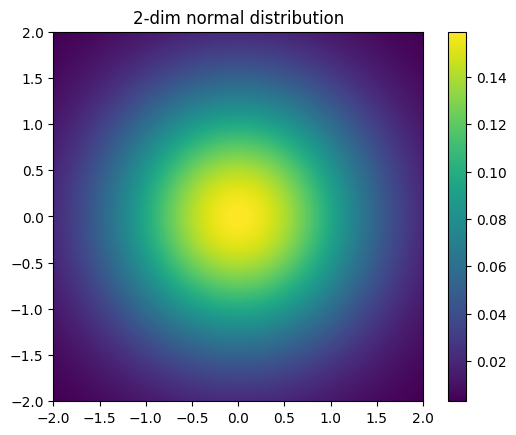

In [10]:
# 二次元正規分布を可視化
plt.title('2-dim normal distribution')
plt.pcolormesh(x, y, p.reshape(x.shape), cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.colorbar()
plt.show()

### ランジュバン・モンテカルロ法

In [11]:
# ランジュバン・モンテカルロ法の実装
def langevin_monte_carlo(dist, num_samples, num_steps, step_size):
    # 初期サンプルを乱数から生成
    x = torch.randn(num_samples, dim, requires_grad=True)
    for i in range(num_steps):
        x.requires_grad_()
        log_p = dist.log_prob(x)
        score = torch.autograd.grad(log_p.sum(), x)[0]
        with torch.no_grad():
            noise = torch.randn(num_samples, dim)
            x = x + step_size * score + np.sqrt(2 * step_size) * noise
    return x

In [12]:
# ランジュバン・モンテカルロ法のパラメータ
num_samples = 100000
num_steps = 1000
step_size = 0.001

In [13]:
# サンプリングの実行
samples = langevin_monte_carlo(dist, num_samples, num_steps, step_size)

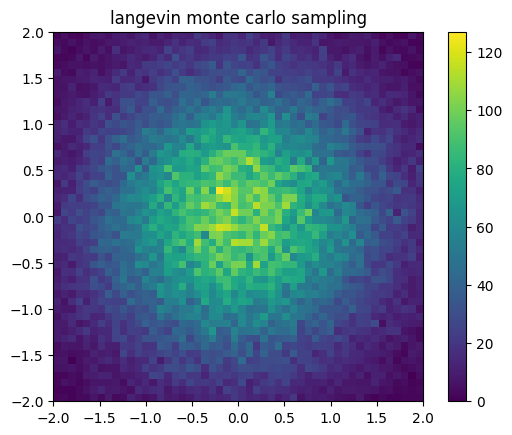

In [14]:
# サンプリング結果の可視化
plt.title('langevin monte carlo sampling')
plt.hist2d(
    samples[:,0], 
    samples[:,1], 
    range=((-2, 2), (-2, 2)), 
    cmap='viridis', 
    bins=50, 
)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.colorbar()
plt.show()

### 二次元混合正規分布

In [15]:
# 平均ベクトル
means = torch.tensor([[0.0, 0.0], [2.0, 2.0], [-2.0, -2.0], [2.0, -2.0]])

# 共分散行列
covs = torch.Tensor([
    [[ 1.0,  0.0],
     [ 0.0,  1.0]],

    [[ 0.6,  0.1],
     [ 0.1,  0.9]],

    [[ 0.8, -0.2],
     [-0.2,  0.8]],
    
    [[ 0.3, 0.2],
     [0.2,  0.8]],
])

# 混合係数
mixture_weights = torch.tensor([0.2, 0.2, 0.4, 0.2])

In [16]:
# 各成分の二次元正規分布を作成
components = [MultivariateNormal(means[i], covs[i]) for i in range(len(means))]

In [17]:
# 混合正規分布を作成
mixture_dist = MixtureSameFamily(
    Categorical(mixture_weights),
    MultivariateNormal(means, covs)
)

In [18]:
# 二次元の格子点の座標を作成
ls = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(ls, ls)
point = torch.tensor(np.vstack([x.flatten(), y.flatten()]).T)
# 格子点の座標における尤度を算出
p = torch.exp(mixture_dist.log_prob(point))

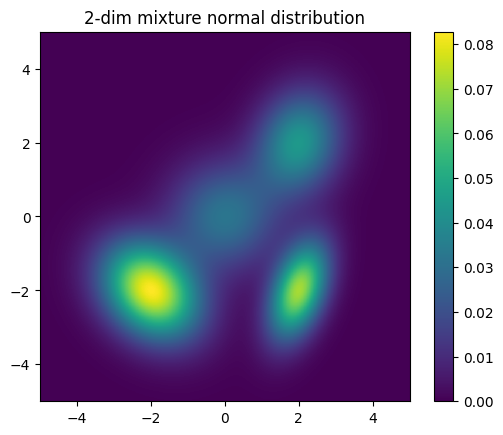

In [19]:
# 二次元正規分布を可視化
plt.title('2-dim mixture normal distribution')
plt.pcolormesh(x, y, p.reshape(x.shape), cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()
plt.show()

### ランジュバン・モンテカルロ法

In [29]:
# ランジュバン・モンテカルロ法のパラメータ
num_samples = 100000
num_steps = 1000
step_size = 0.1

In [30]:
# サンプリングの実行
samples = langevin_monte_carlo(mixture_dist, num_samples, num_steps, step_size)

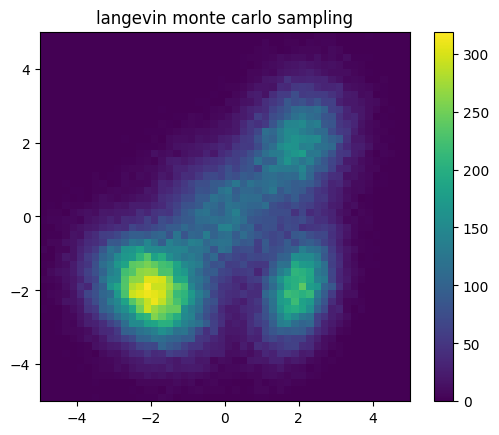

In [31]:
# サンプリング結果の可視化
plt.title('langevin monte carlo sampling')
plt.hist2d(
    samples[:,0], 
    samples[:,1], 
    range=((-5, 5), (-5, 5)), 
    cmap='viridis', 
    bins=50, 
)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()
plt.show()

### 複数のステップサイズで得られた分布の比較

In [45]:
# ランジュバン・モンテカルロ法のパラメータ
num_samples = 100000
num_steps = 1000
step_size_list = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

In [46]:
# 結果の保存先
samples_list = []

# 複数のステップサイズでサンプリング
for step_size in step_size_list:
    
    # サンプリングの実行
    samples = langevin_monte_carlo(mixture_dist, num_samples, num_steps, step_size)
    
    samples_list.append(samples)

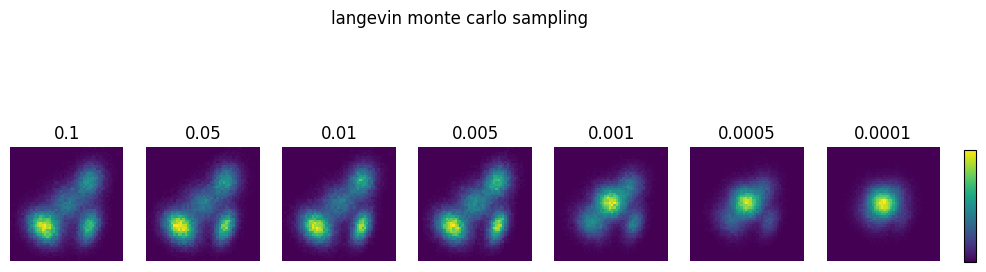

In [101]:
# サンプリング結果の可視化
fig, axes = plt.subplots(1, len(step_size_list), figsize=(12,4))
plt.suptitle('langevin monte carlo sampling')

for i,step_size in enumerate(step_size_list):
    
    axes[i].set_title(step_size)
    im = axes[i].hist2d(
        samples_list[i][:,0], 
        samples_list[i][:,1], 
        range=((-5, 5), (-5, 5)), 
        cmap='viridis', 
        bins=50, 
    )
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].axis('off')

cax = fig.add_axes((0.92, 0.35, 0.01, 0.28))
cbar = plt.colorbar(im[3], cax=cax, orientation='vertical', ticks=mticker.NullLocator())
cbar.ax.set_yticklabels([])
plt.show()